In [1]:
# Notebook to generate data and append it in df
# We use the following format: 
# Edge betweenness, length, max of degree of connecting nodes, sum of degrees of connecting nodes, stress of the edge
# euclidean distance between gradient of KK before and after taking the edge out, Expansion factor, crossings minimized
# difference in average edge length, number of nodes, number of edges

# The last two are kept for normalization purposes.

import pandas as pd
import glob
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from src.graph_dataset import GraphDataset
from src.graph_parser import parseGraphmlFile
from src.graph_utils import stress, total_stress, num_crossings, mean_edge_length, nodes_dict_to_array, distance_matrix
from src.graph_utils import gradient_kamada_kawai, max_neighbour_degrees_norm, sum_neighbour_degrees_norm, expansion_factor_norm, edge_crossings_norm
from src.graph_utils import max_j_node_centrality, sum_j_node_centrality, j_node_centrality, graph_entropy_norm, electro_forces_in_neighbourhood, cos_force_diff_in_neighbourhood

In [3]:
def read_list_of_graphs(dir_name,ext):
    list_graphs = [parseGraphmlFile(dir_name+f,weighted=False,directed=False) for f in os.listdir(dir_name) if f.endswith('.' + ext)]
    return list_graphs

# Generate Dataframe

In [15]:
n = 0
m = 100
draw_f = lambda g: nx.kamada_kawai_layout(g, pos=nx.spectral_layout(g))
benchmarks = ['random-dag', 'rome', 'north']

data = []
for bench in benchmarks:
    list_graphs = read_list_of_graphs(f'../data/{bench}/','graphml')
    for idx_graph, graph in tqdm(list(enumerate(list_graphs[n:m]))):

        # Run Spectral +  Kamada-Kawai
        pos0 = draw_f(graph)

        # Compute general graph attributes
        eb = nx.edge_betweenness(graph)     # edge betweenness
        st = stress(graph, pos0)             # stress
        cross0 = num_crossings(graph, pos0) 
        edgel0 = mean_edge_length(graph, pos0)
        total_stress0 = total_stress(graph, pos0)
        deg = nx.degree(graph, graph.nodes)
        bridges = nx.bridges(graph)
        d0 = distance_matrix(graph)
        graph_entropy = graph_entropy_norm(graph)
        pos0_arr = nodes_dict_to_array(pos0)
        r = 1.

        for idx_edge, e in enumerate(graph.edges):

            n1, n2 = e
            
            force_before_1 = electro_forces_in_neighbourhood(graph,n1,pos0,r) #force in neighbourhood of n1 before relaxation
            force_before_2 = electro_forces_in_neighbourhood(graph,n2,pos0,r) #force in neighbourhood of n2 before relaxation
            force_before = force_before_1 + force_before_2
            # New position removing edge
            graph_copy = graph.copy()
            graph_copy.remove_edges_from([e])
            pos1 = nx.kamada_kawai_layout(graph_copy,pos=pos0)
            pos1_arr = nodes_dict_to_array(pos1)

            cross1 = num_crossings(graph, pos1) 
            edgel1 = mean_edge_length(graph, pos1)
            total_stress1 = total_stress(graph, pos1)
            deg = nx.degree(graph, graph.nodes)
            exp_factor_norm = expansion_factor_norm(pos0_arr,pos1_arr)
            edge_cross_norm = edge_crossings_norm(cross0-cross1, len(graph_copy.edges))
            d1 = distance_matrix(graph_copy)
            grad_diff = np.linalg.norm(gradient_kamada_kawai(pos0_arr,d0)-gradient_kamada_kawai(pos1_arr,d1))
            # Extra attributes
            max_deg = max(deg[n1], deg[n2])
            min_deg = min(deg[n1], deg[n2])
            sum_neighbour_deg_norm = sum_neighbour_degrees_norm(graph_copy,e)
            max_neighbour_deg_norm = max_neighbour_degrees_norm(graph_copy,e)
            max_jnc = max_j_node_centrality(graph_copy,pos1_arr,e)
            sum_jnc = sum_j_node_centrality(graph_copy,pos1_arr,e)
            nnodes, nedges = len(graph.nodes), len(graph.edges)
            graph_copy_entropy = graph_entropy_norm(graph_copy)
            force_after_1 = electro_forces_in_neighbourhood(graph_copy,n1,pos1,r) #force in neighbourhood of n1 before relaxation
            force_after_2 = electro_forces_in_neighbourhood(graph_copy,n2,pos1,r) #force in neighbourhood of n2 before relaxation
            force_after = force_after_1 + force_after_2
            cos_force_diff = cos_force_diff_in_neighbourhood(force_before, force_after)
            row = [idx_graph, idx_edge, nnodes, nedges, eb[e], st[e], max_deg, min_deg, e in bridges,
                total_stress0 - total_stress1, cross0 - cross1, edgel0 - edgel1,
                bench, exp_factor_norm, edge_cross_norm, sum_neighbour_deg_norm, max_neighbour_deg_norm, max_jnc, sum_jnc, graph_copy_entropy-graph_entropy, cos_force_diff, force_before-force_after]
            data.append(row)

    cols = ['graph_id', 'edge_id', 'num_nodes', 'num_edges', 'edge_betweenness', 'stress', 'max_deg', 'min_deg', 'is_bridge', 'diff_stress', 'diff_cross', 'diff_edgelength', 'benchmark', 'exp_factor_norm', 'edge_cross_norm', 'sum_neighbour_deg_norm', 'max_neighbour_deg_norm','max_jnc','sum_jnc','diff_graph_entropy_norm','cos_force_diff','diff_force']
    df = pd.DataFrame(data, columns=cols)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/nathanielmitrani/Documents/GitHub/EdgeRelaxationGraphDrawing/src/graph_utils.py:730: RuntimeWarning: divide by zero encountered in double_scalars
  L[i] = np.sum([L[j]*np.linalg.norm(layout[i]-layout[j])
/Users/nathanielmitrani/Documents/GitHub/EdgeRelaxationGraphDrawing/src/graph_utils.py:733: RuntimeWarning: invalid value encountered in divide
  L /= sumCentralities
/Users/nathanielmitrani/Documents/GitHub/EdgeRelaxationGraphDrawing/src/graph_utils.py:788: RuntimeWarning: divide by zero encountered in log
  return -np.sum([degree[node]/nNodes*np.log(degree[node]/nNodes) for node in G.nodes])/np.log(nNodes)
/Users/nathanielmitrani/Documents/GitHub/EdgeRelaxationGraphDrawing/src/graph_utils.py:788: RuntimeWarning: invalid value encountered in double_scalars
  return -np.sum([degree[node]/nNodes*np.log(degree[node]/nNodes) for node in G.nodes])/np.log(nNodes)
100%|██████████| 1/1 [49:59<00:00, 2999.81s/it]


In [17]:
df.head()

,graph_id,edge_id,num_nodes,num_edges,edge_betweenness,stress,max_deg,min_deg,is_bridge,diff_stress,...,benchmark,exp_factor_norm,edge_cross_norm,sum_neighbour_deg_norm,max_neighbour_deg_norm,max_jnc,sum_jnc,diff_graph_entropy_norm,cos_force_diff,diff_force
0,0,0,13,22,0.057692,0.381040,6,4,False,0.401731,...,random-dag,0.164711,0.019048,0.615385,0.384615,0.653991,1.145662,-0.005314,0,"[0.0, 0.0]"
1,0,1,13,22,0.012821,0.652965,4,4,False,-0.014228,...,random-dag,0.001457,0.000000,0.461538,0.230769,3.389527,0.716681,-0.018930,0,"[0.0, 0.0]"
2,0,2,13,22,0.044872,0.517387,6,4,False,0.355418,...,random-dag,0.181125,0.019048,0.615385,0.384615,0.080534,0.246608,-0.005314,0,"[0.0, 0.0]"
3,0,3,13,22,0.038462,0.573103,5,4,False,0.003943,...,random-dag,0.210177,0.019048,0.538462,0.307692,1.305168,3.216422,-0.011353,0,"[0.0, 0.0]"
4,0,4,13,22,0.102564,0.617011,6,6,False,-0.237790,...,random-dag,0.069743,0.000000,0.769231,0.384615,0.795235,1.871538,0.008302,0,"[0.0, 0.0]"


In [8]:
df.to_csv('../data/graph_train_3.csv')

# Some stats

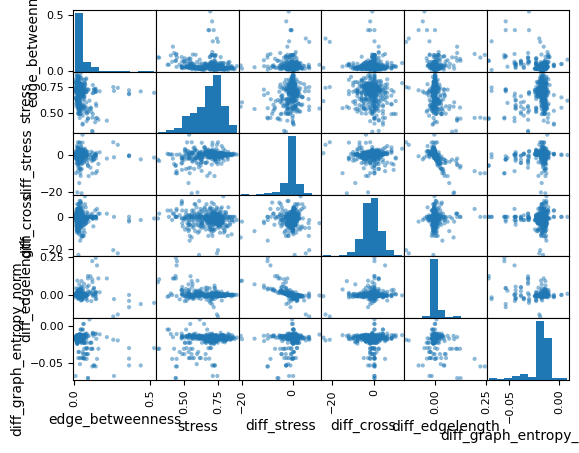

In [14]:
pd.plotting.scatter_matrix(df[['edge_betweenness', 'stress', 'diff_stress', 'diff_cross', 'diff_edgelength','diff_graph_entropy_norm']]);

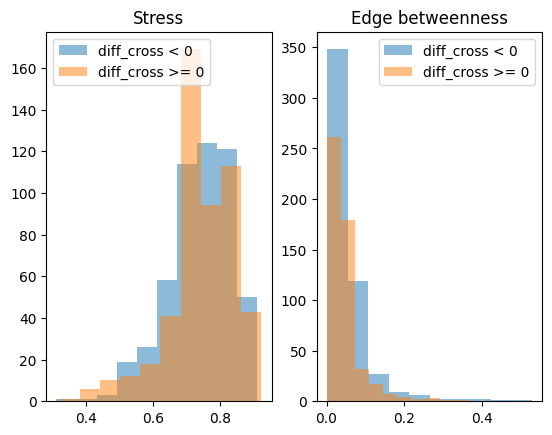

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

x = df[df['diff_cross'] < 0].stress
y = df[df['diff_cross'] >= 0].stress
ax1.hist(x, bins=10, alpha=0.5, label='diff_cross < 0')
ax1.hist(y, bins=10, alpha=0.5, label='diff_cross >= 0')
ax1.legend(loc='upper left')
ax1.set_title('Stress')

x = df[df['diff_cross'] < 0].edge_betweenness
y = df[df['diff_cross'] >= 0].edge_betweenness
ax2.hist(x, bins=10, alpha=0.5, label='diff_cross < 0')
ax2.hist(y, bins=10, alpha=0.5, label='diff_cross >= 0')
ax2.legend(loc='upper right')
ax2.set_title('Edge betweenness')

plt.show()

# Append dataframes

In [9]:
df1 = pd.read_csv('../data/graph_train_1.csv')
df2 = pd.read_csv('../data/graph_train_2.csv')
df1.append(df2,ignore_index=True)
df1.drop_duplicates()
df1.to_csv('../data/graph_train_full.csv')

C:\Users\natha\AppData\Local\Temp\ipykernel_1328\2478354620.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1.append(df2,ignore_index=True)


In [13]:
print(len(pd.read_csv('../data/graph_train_2.csv')))
len(pd.read_csv('../data/graph_train_full.csv'))

76461


20130